Split plaintext files into test train and validation

In [1]:
import os
import random

random.seed(13)
plaintext_directory = os.path.join("amlh_nlp_dataset", "amlh_nlp_dataset", "plaintext_data")
plaintext_fnames = [fname for fname in os.listdir(plaintext_directory) if fname.endswith(".txt")]

random.shuffle(plaintext_fnames)
val_index = int(0.1*len(plaintext_fnames))
test_index = val_index + int(0.2*len(plaintext_fnames))
fnames_val = plaintext_fnames[:val_index]
fnames_test = plaintext_fnames[val_index:test_index]
fnames_train = plaintext_fnames[test_index:]
print(len(fnames_train), len(fnames_val), len(fnames_test))

346 49 98


In [2]:
def preprocess_text(text):
    text = text.replace("\n ", "\n").replace("\n\n", " ").replace(":", " ").replace("  ", " ").lower()
    return text

def extract_centred_string(text, center_idx, length):
    lower_bound = max(0, center_idx - int(length/2))
    upper_bound = min(len(text), center_idx + int(length/2))
    center_idx = int(length/2) if lower_bound > 0 else center_idx
    return text[lower_bound:upper_bound], center_idx

def read_in_and_preprocess_plaintext(plaintext_directory, fnames, window_size, n_samples=10):
    text = []
    for fname in fnames:
        filepath = os.path.join(plaintext_directory, fname)
        with open(filepath, 'r', encoding="utf8") as plaintext_file:
            # Read in file and strip extraneous whitespace
            plaintext = plaintext_file.read()
            plaintext = preprocess_text(plaintext)
            for _ in range(n_samples):
                central_idx = random.randint(0, len(plaintext))
                extract, _ = extract_centred_string(plaintext, central_idx, window_size)
                text = text + [extract]
                
    return text


In [3]:
window_size = 256
text_train = read_in_and_preprocess_plaintext(plaintext_directory, fnames_train, window_size)
text_val = read_in_and_preprocess_plaintext(plaintext_directory, fnames_val, window_size)
text_test = read_in_and_preprocess_plaintext(plaintext_directory, fnames_test, window_size)

print(len(text_train), len(text_val), len(text_test))
print(text_train[0])

3460 490 980
harp dissection was carried down in the subcutaneous tissues and bovie electrocautery was used to reach the skull. a burr hole was placed down low using a craniotome. a craniotomy was turned and then enlarged as a craniectomy to at least 4 cm in diameter. 


Tokenise use Bert-Tokeniser

In [4]:
from transformers import BertTokenizerFast, BertForMaskedLM
import torch
max_token_length = 128
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
inputs_train = tokenizer(text_train, return_tensors='pt', padding='max_length', max_length=max_token_length)
inputs_val = tokenizer(text_val, return_tensors='pt', padding='max_length', max_length=max_token_length)
inputs_test = tokenizer(text_test, return_tensors='pt', padding='max_length', max_length=max_token_length)

print(inputs_train.input_ids.size(), inputs_val.input_ids.size(), inputs_test.input_ids.size())
print(inputs_train.input_ids[0])

torch.Size([3460, 128]) torch.Size([490, 128]) torch.Size([980, 128])
tensor([  101, 14601,  4487, 11393,  7542,  2001,  3344,  2091,  1999,  1996,
         4942, 12690, 17191, 14095,  1998,  8945, 13469, 16175,  3540, 19901,
         2100,  2001,  2109,  2000,  3362,  1996,  7412,  1012,  1037, 22715,
         4920,  2001,  2872,  2091,  2659,  2478,  1037, 13675,  7088, 11439,
         4168,  1012,  1037, 13675,  7088, 11439,  8029,  2001,  2357,  1998,
         2059, 11792,  2004,  1037, 13675,  7088, 22471, 16940,  2000,  2012,
         2560,  1018,  4642,  1999,  6705,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,  

Create masked labels

In [5]:
def add_masked_labels_to_inputs(inputs):
    inputs['labels'] = inputs.input_ids.detach().clone()
    # create random array of floats with equal dimensions to input_ids tensor
    rand = torch.rand(inputs.input_ids.shape)
    # create mask array excluding masking special tokens
    mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
            (inputs.input_ids != 102) * (inputs.input_ids != 0)
    # Extract indicies to be masked
    selection = []
    for i in range(inputs.input_ids.shape[0]):
        selection.append(
            torch.flatten(mask_arr[i].nonzero()).tolist()
        )
    # Mask them
    for i in range(inputs.input_ids.shape[0]):
        inputs.input_ids[i, selection[i]] = 103
    return inputs

In [6]:
inputs_train = add_masked_labels_to_inputs(inputs_train)
inputs_val = add_masked_labels_to_inputs(inputs_val)
inputs_val = add_masked_labels_to_inputs(inputs_test)

In [7]:
print(inputs_train.labels.size(), inputs_val.labels.size(), inputs_test.labels.size())
print(inputs_train.labels[0])

torch.Size([3460, 128]) torch.Size([980, 128]) torch.Size([980, 128])
tensor([  101, 14601,  4487, 11393,  7542,  2001,  3344,  2091,  1999,  1996,
         4942, 12690, 17191, 14095,  1998,  8945, 13469, 16175,  3540, 19901,
         2100,  2001,  2109,  2000,  3362,  1996,  7412,  1012,  1037, 22715,
         4920,  2001,  2872,  2091,  2659,  2478,  1037, 13675,  7088, 11439,
         4168,  1012,  1037, 13675,  7088, 11439,  8029,  2001,  2357,  1998,
         2059, 11792,  2004,  1037, 13675,  7088, 22471, 16940,  2000,  2012,
         2560,  1018,  4642,  1999,  6705,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,  

Load into datasets and dataloaders

In [8]:
class MTSamplesDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return self.encodings.input_ids[idx], self.encodings.attention_mask[idx], self.encodings.labels[idx]
    def __len__(self):
        return len(self.encodings.input_ids)

In [9]:
datasets = {"train": MTSamplesDataset(inputs_train), "val": MTSamplesDataset(inputs_val), "test": MTSamplesDataset(inputs_test)}
dataloaders = {key: torch.utils.data.DataLoader(dataset, batch_size=8) for key, dataset in datasets.items()}
dataloaders["train"].shuffle = True

print([len(dataset) for dataset in datasets.values()])
print([len(dataloader) for dataloader in dataloaders.values()])

[3460, 980, 980]
[433, 123, 123]


Load model and optimiser

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.to(device)
model.train()
print()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
from transformers import AdamW
# initialize optimizer
optim = AdamW(model.parameters(), lr=5e-5)

Run training

In [12]:
from tqdm import tqdm  # for our progress bar

num_steps = 100
loss_log = {"train":[], "val":[]}
optim.zero_grad()
with tqdm(total=num_steps) as pbar:
    for step in range(num_steps):
        # setup loop with TQDM and dataloader
        # loop = tqdm(num_steps, leave=True)
        for phase in ["train", "val"]:
            model = model.train() if phase == 'train' else model.eval()
            input_ids, attention_mask, labels = next(iter(dataloaders[phase]))
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(input_ids, attention_mask=attention_mask,
                            labels=labels)
                loss = outputs.loss
                if phase == 'train':
                    loss.backward()
                    optim.step()
                    optim.zero_grad()
            loss_log[phase].append(loss.item()/len(input_ids))
        # Print relevant info to progress bar
        pbar.update(1)
        pbar.set_description(f'Step number {step}')
        pbar.set_postfix(loss=loss_log["val"][-1])

Step number 99: 100%|████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s, loss=0.031]


In [13]:
model_file = os.path.join("models", 'Bert_Finetuned_MTSamples.pt')
torch.save(model.state_dict(), model_file)

Text(0.5, 0, 'Num Steps')

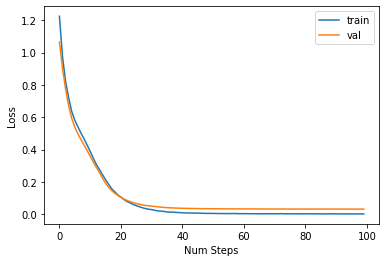

In [14]:
import matplotlib.pyplot as plt
for phase, loss in loss_log.items():
    plt.plot(loss[:100], label=phase)
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Num Steps")

In [15]:
def extract_text_from_annotations(annotations, plaintext_directory, window_size): 
    extracts = {"text": [], "idxs":[], "labels":[], "anno":[]}
    for _, anno in annotations.iterrows():
        anno_filepath = os.path.join(plaintext_directory, anno.file)
        anno_start = anno.start
        anno_length = anno.end - anno.start
        with open(anno_filepath, 'r', encoding="utf8") as plaintext_file:
            plaintext = plaintext_file.read()
            preprocessed_start = preprocess_text(plaintext[:anno_start])
            preprocessed_end = preprocess_text(plaintext[anno_start:])
            offset = len(plaintext[:anno_start]) - len(preprocessed_start)
            
            anno_start_pre = anno_start - offset
            plaintext = preprocessed_start + preprocessed_end
            extract, start_idx = extract_centred_string(plaintext, anno_start_pre, window_size)
            extracts["text"] += [extract]
            extracts["idxs"] += [[start_idx, start_idx+anno_length]]
            extracts["labels"] += [anno["class"]]
            extracts["anno"] += [extract[start_idx: start_idx+anno_length]]
    return extracts

In [16]:
import pandas as pd

annotations = pd.read_csv(os.path.join("amlh_nlp_dataset", "amlh_nlp_dataset","amlh_coursework_annotated.csv"))
annotations_train = annotations[annotations.file.isin(fnames_train+fnames_val)]
annotations_test = annotations[annotations.file.isin(fnames_test)]

extracts_train = extract_text_from_annotations(annotations_train, plaintext_directory, window_size)
extracts_test = extract_text_from_annotations(annotations_test, plaintext_directory, window_size)

print([len(feature) for feature in extracts_train.values()])
print([len(feature) for feature in extracts_test.values()])

[12694, 12694, 12694, 12694]
[2962, 2962, 2962, 2962]


In [17]:
inputs_train = tokenizer(extracts_train["text"], return_tensors='pt', padding='max_length', max_length=128, return_offsets_mapping=True)
inputs_test = tokenizer(extracts_test["text"], return_tensors='pt', padding='max_length', max_length=128, return_offsets_mapping=True)

extracts_train = {**extracts_train, **inputs_train}
extracts_test = {**extracts_test, **inputs_test}

print(inputs_train.input_ids.size(), inputs_test.input_ids.size())

torch.Size([12694, 128]) torch.Size([2962, 128])


In [18]:
import numpy as np

def get_tokens_of_interest_idxs(offset_mapping_list, idxs_list, text, annos):
    toi_idxs = []
    for offset_mapping, idxs, text, anno in zip(offset_mapping_list, idxs_list, text, annos):
        try:
            token_start = np.where(offset_mapping[:, 0]==idxs[0])[0][0]
            token_end = np.where(offset_mapping[:, 1]==idxs[1])[0][0]
            toi_idxs.append([token_start, token_end+1])
        except:
            # Incorrect annoation of cannot as can
            if text[idxs[0]:idxs[1]] == "can":
                toi_idxs.append([token_start, token_start+1])
                idxs[1] += 3
    return toi_idxs
extracts_train["toi_idxs"] = get_tokens_of_interest_idxs(extracts_train["offset_mapping"], extracts_train["idxs"], extracts_train["text"], extracts_train["anno"])
extracts_test["toi_idxs"] = get_tokens_of_interest_idxs(extracts_test["offset_mapping"], extracts_test["idxs"], extracts_test["text"], extracts_test["anno"])
print(extracts_train["toi_idxs"][:10])
print(len(extracts_train["toi_idxs"]), len(extracts_test["toi_idxs"]))

[[28, 30], [28, 32], [43, 44], [26, 28], [24, 26], [37, 39], [36, 38], [7, 8], [11, 17], [20, 22]]
12694 2962


In [19]:
class MT_NERSamplesDataset(torch.utils.data.Dataset):
    def __init__(self, extracts):
        self.extracts = extracts
    def __getitem__(self, idx):
        return {key: value[idx] for key, value in self.extracts.items()}
    def __len__(self):
        return len(self.extracts["input_ids"])
    def get_phrase(sample):
        text = sample["text"]
        idxs = sample["idxs"]
        return text[idxs[0]:idxs[1]]
    def get_decode_tokens(sample, tokenizer):
        input_ids = sample["input_ids"]
        toi_idxs = sample["toi_idxs"]
        return tokenizer.decode(input_ids[toi_idxs[0]:toi_idxs[1]])
    def sample_to_string(sample, tokenizer):
        string = "Label: "+ sample["labels"] + ","
        string += " Orginal anno: "+ sample["anno"] + ","
        string += " Indexed anno: "+ MT_NERSamplesDataset.get_phrase(sample) + ","
        string += " Tokenised anno: "+ MT_NERSamplesDataset.get_decode_tokens(sample, tokenizer)
        return string

In [20]:
datasets = {"train": MT_NERSamplesDataset(extracts_train), "test": MT_NERSamplesDataset(extracts_test)}
dataloaders = {key: torch.utils.data.DataLoader(dataset, batch_size=8) for key, dataset in datasets.items()}

print([len(dataset) for dataset in datasets.values()])
print([len(dataloader) for dataloader in dataloaders.values()])
sample = datasets["train"][0]
print(sample.keys())
print(MT_NERSamplesDataset.sample_to_string(sample, tokenizer))

[12694, 2962]
[1587, 371]
dict_keys(['text', 'idxs', 'labels', 'anno', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'toi_idxs'])
Label: Disease_Syndrome, Orginal anno: colon cancer, Indexed anno: colon cancer, Tokenised anno: colon cancer


In [27]:
def get_hidden_layer_reps(model, dataloader, device, max_token_length, layer):
    hidden_layer_reps = torch.zeros(len(dataloader.dataset), max_token_length, model.config.hidden_size)
    idx = 0
    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        with torch.set_grad_enabled(False):
            outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        batch_size = input_ids.size(0)
        hidden_layer_reps[idx:idx+batch_size] = outputs.hidden_states[layer]
        idx += batch_size
    return hidden_layer_reps.cpu()

def get_av_hidden_layer_rep_for_toi_layer(hidden_layer_reps, toi_idxs):
    av_hidden_layer_rep_toi = torch.zeros(hidden_layer_reps.size(0), hidden_layer_reps.size(2))
    for i, (hidden_layer_rep, toi_idx) in enumerate(zip(hidden_layer_reps, toi_idxs)):
        hidden_layer_rep_oi = hidden_layer_rep[toi_idx[0]:toi_idx[1]]
        av_hidden_layer_rep_toi[i] = hidden_layer_rep_oi.mean(dim=0)
    return av_hidden_layer_rep_toi

In [28]:
model.to(device)
model.eval()
hidden_final_layer_train = get_hidden_layer_reps(model, dataloaders["train"], device, max_token_length, -1)
hidden_final_layer_toi_train = get_av_hidden_layer_rep_for_toi_layer(hidden_final_layer_train, extracts_train["toi_idxs"])

hidden_final_layer_test = get_hidden_layer_reps(model, dataloaders["test"], device, max_token_length, -1)
hidden_final_layer_toi_test = get_av_hidden_layer_rep_for_toi_layer(hidden_final_layer_test, extracts_test["toi_idxs"])
model.to("cpu")

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

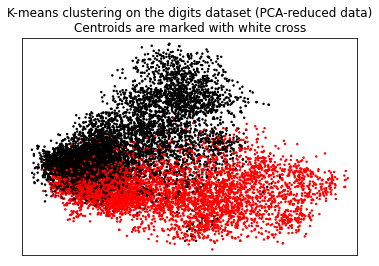

In [31]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

labels = extracts_train["labels"]
scaled_data = StandardScaler().fit_transform(hidden_final_layer_toi_train)
reduced_data = PCA(n_components=2).fit_transform(scaled_data)
kmeans = KMeans(init="k-means++", n_clusters=2, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1)
# plt.clf()
# plt.imshow(Z, interpolation="nearest",
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired, aspect="auto", origin="lower")

colours = ['k' if label == "Disease_Syndrome" else "r" for label in labels]
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=colours, s=2)
# Plot the centroids as a white X
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
#             color="w", zorder=10)
plt.title("K-means clustering on the digits dataset (PCA-reduced data)\n"
          "Centroids are marked with white cross")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()